# Demand Forecast

In this notebook we will create a demand forecast model. We follow these steps:
 - Read the data
 - Explore, process/clean the data, iteratively
 - Model demand

In [1]:
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

## Read the data

We read the provided data with Pandas:

In [2]:
df = pd.read_csv("data.csv")

## Exploration and Processing
We generate a profile of the raw data:

In [3]:
profile = ProfileReport(df.reset_index(drop=True), title="Raw Data Profiling Report")
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/home/acanterla/.asdf/installs/python/3.9.9/lib/python3.9/site-packages/multimethod/__init__.py:315: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return func(*args, **kwargs)
/home/acanterla/.asdf/installs/python/3.9.9/lib/python3.9/site-packages/multimethod/__init__.py:315: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  return func(*args, **kwargs)


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In the report above we see some issues with the data:
 - Date column was read as string and has missing data
 - Demand column was read as string. Upon closer investigation we found that some numbers are in parenthesis.
 - Duplicated rows
 
We process the data to deal with those issues: 

In [4]:
df.Date=pd.to_datetime(df.Date)
# Some numbers are in parentheses, not sure if it can be ignored or if they are negative
df.Order_Demand = df.Order_Demand.apply(lambda s: eval(s))
df = df.drop_duplicates()
df = df.dropna()

In [5]:
df.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012-07-27,100
1,Product_0979,Whse_J,Category_028,2012-01-19,500
2,Product_0979,Whse_J,Category_028,2012-02-03,500
3,Product_0979,Whse_J,Category_028,2012-02-09,500
4,Product_0979,Whse_J,Category_028,2012-03-02,500


We can then generate a new profile:

In [6]:
profile = ProfileReport(df.reset_index(drop=True), title="Processed Data (1) Profiling Report")
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/home/acanterla/.asdf/installs/python/3.9.9/lib/python3.9/site-packages/multimethod/__init__.py:315: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return func(*args, **kwargs)
/home/acanterla/.asdf/installs/python/3.9.9/lib/python3.9/site-packages/multimethod/__init__.py:315: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  return func(*args, **kwargs)


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

The data seems to be in much better shape now. Something interesting is that Demand can be zero (2.1% rows), why is that? We'll assume that those rows can be discarded.

In [7]:
df = df.loc[df.Order_Demand != 0,:]

The maximum value for the demand is 4e6, which is a bit large. Could it be an error? Let's see the highest values (the report above shows this as well):

In [8]:
df.Order_Demand.sort_values(ascending=False).head(n=10)

20892     4000000
72638     3000000
20477     3000000
222266    3000000
258396    2560000
659055    2500000
659050    2500000
659046    2500000
108179    2500000
871363    2500000
Name: Order_Demand, dtype: int64

We see that there other values of a similar order. It seem like demand has just a long tail. 

It's probably a good idea to compress the range of this variable with a logarithm, for example if we're going to model the data with a linear model later.

In [9]:
df = df.assign(Order_Demand_Log = np.log(df.Order_Demand))

The resulting variable:

<AxesSubplot:>

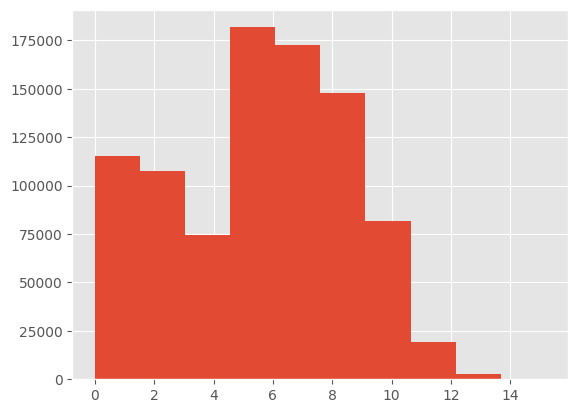

In [10]:
df.Order_Demand_Log.hist()

We generate a last profile to check that everything is in order:

In [11]:
profile = ProfileReport(df.reset_index(drop=True), title="Processed Data (2) Profiling Report")
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/home/acanterla/.asdf/installs/python/3.9.9/lib/python3.9/site-packages/multimethod/__init__.py:315: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return func(*args, **kwargs)
/home/acanterla/.asdf/installs/python/3.9.9/lib/python3.9/site-packages/multimethod/__init__.py:315: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  return func(*args, **kwargs)
/home/acanterla/.asdf/installs/python/3.9.9/lib/python3.9/site-packages/multimethod/__init__.py:315: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  return func(*args, **kwargs)
/home/acanterla/.asdf

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

## Insights
Let's analyse which warehouses, products and categories are driving demand:

In [12]:
df.groupby(["Warehouse"]).Order_Demand.sum().sort_values(ascending=False)

Warehouse
Whse_J    2997451054
Whse_S    1022023779
Whse_C     562745666
Whse_A     145486748
Name: Order_Demand, dtype: int64

In [13]:
df.groupby(["Product_Code"]).Order_Demand.sum().sort_values(ascending=False).head(20)

Product_Code
Product_1359    396272000
Product_1248    267576000
Product_0083    209303000
Product_1341    163874000
Product_1241    112930000
Product_1432     96056000
Product_1295     91478900
Product_1245     85177000
Product_1451     84683000
Product_1274     81015000
Product_1286     77580500
Product_1480     77114000
Product_1264     76855000
Product_1350     74741000
Product_1287     70665500
Product_1016     69070500
Product_1382     63307900
Product_1378     62763200
Product_1342     61247000
Product_1294     58322100
Name: Order_Demand, dtype: int64

In [14]:
df.groupby(["Product_Category"]).Order_Demand.sum().sort_values(ascending=False)

Product_Category
Category_019    3865329704
Category_006     394246662
Category_005     189479510
Category_007     122320694
Category_028      48324589
Category_033      40730000
Category_030      40389203
Category_021       4414857
Category_032       4333098
Category_009       3741464
Category_023       3277031
Category_011       2857573
Category_020       2345670
Category_001       1637962
Category_024       1046217
Category_015        828085
Category_022        603259
Category_025        486000
Category_003        385926
Category_013        307292
Category_026        272716
Category_004         95517
Category_012         69510
Category_017         48620
Category_018         44983
Category_029         23348
Category_010         19979
Category_008         17345
Category_016         16850
Category_031         12756
Category_002           624
Category_027           103
Category_014           100
Name: Order_Demand, dtype: int64

Let's visualize the most popular category:

<AxesSubplot:title={'center':'Demand category 19, monthly'}, xlabel='Date'>

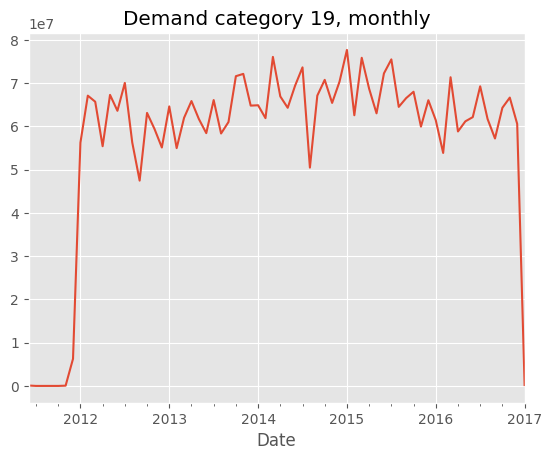

In [15]:
df.loc[df.Product_Category=='Category_019',:].set_index("Date").resample("1m").Order_Demand.sum().plot(title="Demand category 19, monthly")

<AxesSubplot:title={'center':'Demand (Log) category 19, monthly'}, xlabel='Date'>

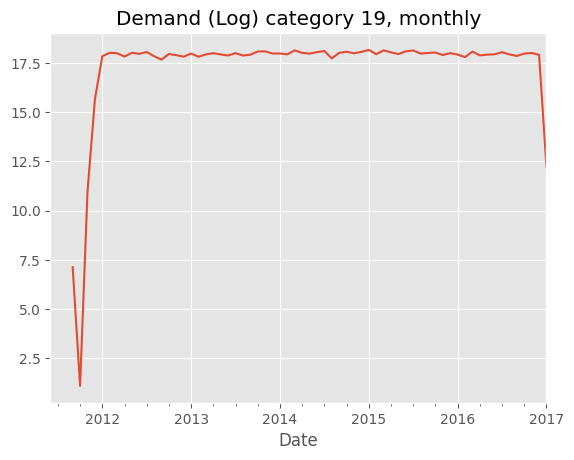

In [16]:
df.loc[df.Product_Category=='Category_019',:].set_index("Date").resample("1m").Order_Demand.sum().apply(np.log).plot(title="Demand (Log) category 19, monthly")

Let's visualize a less popular category:

<AxesSubplot:title={'center':'Demand category 31, monthly'}, xlabel='Date'>

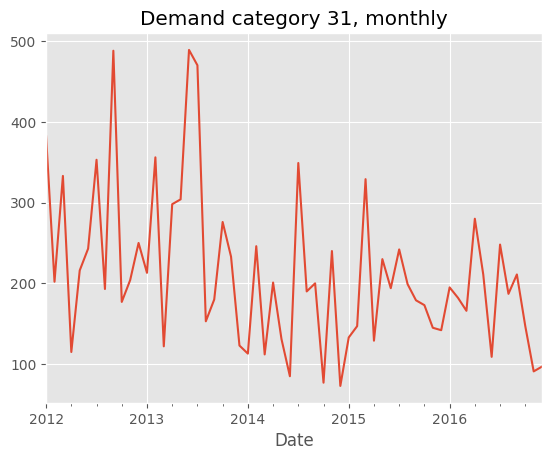

In [17]:
df.loc[df.Product_Category=='Category_031',:].set_index("Date").resample("1m").Order_Demand.sum().plot(title="Demand category 31, monthly")

Difficult to understand what's going on without knowledge of what these products actually are. The behavior of these two categories is a bit different though. This less popular category had some peaks in the middle of the year in 2012 and 2013 and 2014. Maybe it could be something related to bbqs during sprint/summer?

Let's decompose in trend and season:

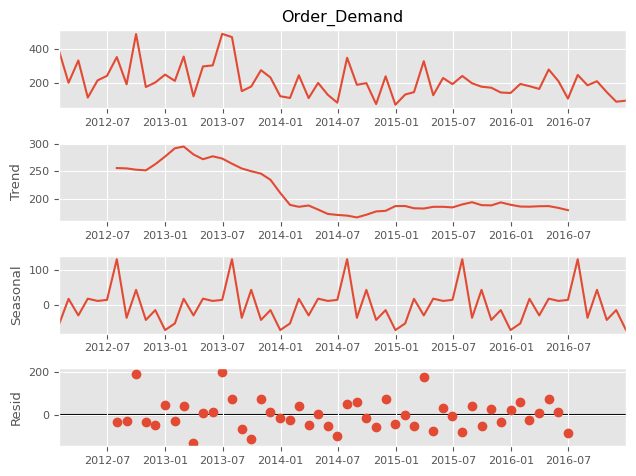

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose
data = df.loc[df.Product_Category=='Category_031',:].set_index("Date").resample("1m").Order_Demand.sum()
result = seasonal_decompose(data, model='additive')
plt.rcParams["font.size"] = "8"
result.plot();

Below we visualize the most popular product. 

<AxesSubplot:title={'center':'Demand product 1359, monthly'}, xlabel='Date'>

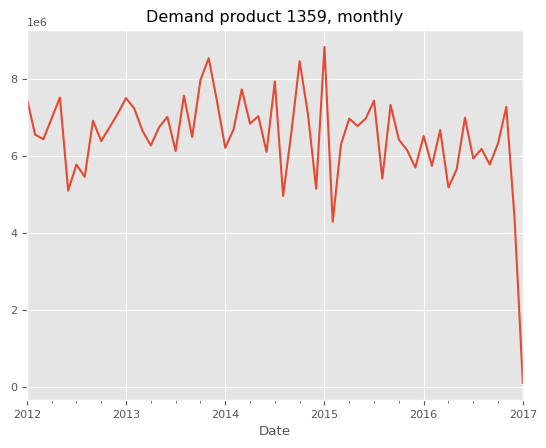

In [19]:
df.loc[df.Product_Code=='Product_1359',:].set_index("Date").resample("1m").Order_Demand.sum().plot(title="Demand product 1359, monthly")

## Predictive Model - Autoregressive
We want to build a predictive model for the demand. An important question is the time aggregation (daily demand, weekly, etc.) and horizon (how long in advance). When it comes to the time aggregation, for some types of products, we may need weekly forecasts, for some others maybe monthly is fine. In some cases, e.g. special meat products for xmas, we probably need forecasts many months ahead.

We consider the most popular product and predicting demand (logarithmic) at the month level.

We will start with a very simple model: an autoregressive model (https://www.statsmodels.org/dev/examples/notebooks/generated/autoregressions.html). 
This model is easy to understand, it's fast to train and to use for inference.
If this model's performance is not good enough, we can explore more complex models later.

Let's look at the partial autocorrelation function, which can help us choose a suitable lag for the model. Let's consider lags of up to 20 weeks.

<AxesSubplot:title={'center':'Demand (log) product 1359, weekly'}, xlabel='Date'>

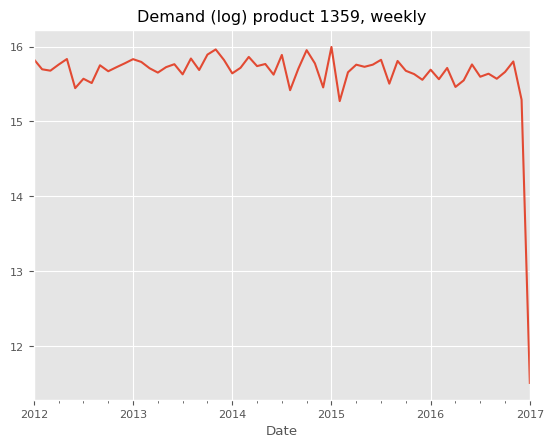

In [20]:
data = df.loc[df.Product_Code=='Product_1359',:].set_index("Date").resample("1m").Order_Demand.sum().apply(np.log)
data.plot(title="Demand (log) product 1359, weekly")

Our models will be trained with the first 90% of the samples, and we will test on the last 10%. This is probably not the best way of testing. Last 10% could cover only a special period, e.g. last months in the last year, which includes xmas. There are smarter ways of testing models for time series (e.g. cross-validation on a rolling basis), but we can leave that for future work. 

In [21]:
n = data.shape[0]
n_train = int(n*0.9)
data_train = data[:n_train]
data_test = data[n_train:]

/home/acanterla/.asdf/installs/python/3.9.9/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


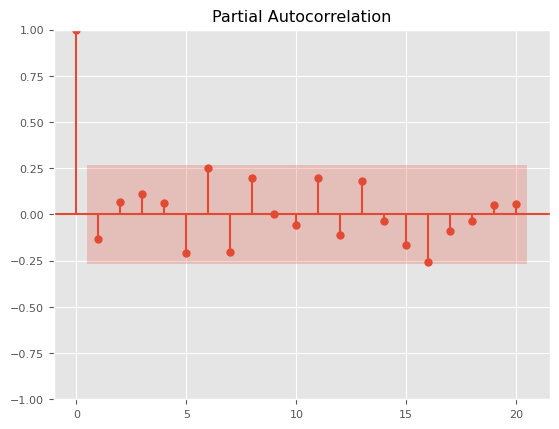

In [22]:
from statsmodels.graphics.tsaplots import plot_pacf
nlags=20
pacf = plot_pacf(data_train, lags=nlags)

We see that there's not a very strong correlation with previous lags. We can start considering 8 lags:

In [23]:
from statsmodels.tsa.ar_model import AutoReg
nlags=8
model = AutoReg(data_train, lags=nlags, seasonal=False)
model_fit = model.fit()

Let's look at the model:

In [24]:
model_fit.params

const              11.253034
Order_Demand.L1    -0.076228
Order_Demand.L2     0.012228
Order_Demand.L3     0.173004
Order_Demand.L4     0.028913
Order_Demand.L5    -0.148562
Order_Demand.L6     0.235866
Order_Demand.L7    -0.124090
Order_Demand.L8     0.182548
dtype: float64

In [25]:
train_hat = model_fit.predict(start=0, end=n_train-1)

In [26]:
preds = []
for t in range(n_train, n):
    pred = model_fit.params[0] + np.sum(model_fit.params[1:]*data[t-nlags:t].values[::-1])
    preds.append(pred)
test_hat = pd.Series(preds, index = data_test.index)

Let's plot the real and predicted orders. The dotted line shows the start of the test dataset.

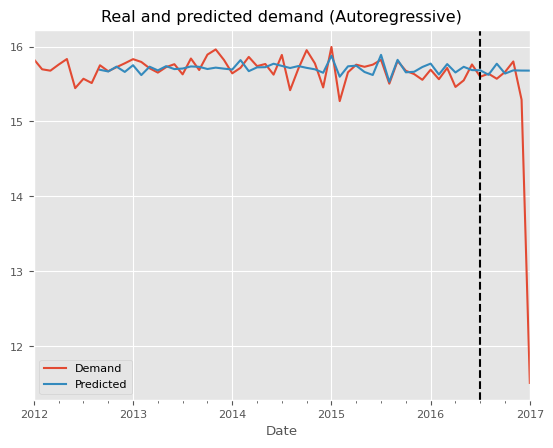

In [27]:
data.plot()
ax = pd.concat([train_hat, test_hat]).plot(title="Real and predicted demand (Autoregressive)")
ax.axvline(data.index[n_train], color="black", linestyle="--")
ax.legend(["Demand", "Predicted"])

Evaluation: We can score the model with the root mean squared error metric. However, note that it's difficult to explain what the mse of logarithmic demand means. 

In [28]:
from sklearn.metrics import mean_squared_error
from math import sqrt

train_score = sqrt(mean_squared_error(data_train[nlags:], train_hat[nlags:]))
print(f'Train RMSE: {train_score:.3f}')
test_score = sqrt(mean_squared_error(data_test, test_hat))
print(f'Test RMSE: {test_score:.3f}')

Train RMSE: 0.127
Test RMSE: 1.584


# Predictive Model - Prophet

Prophet is a modern tool for forecasting developed by Facebook:

"Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well." (https://facebook.github.io/prophet/).

In [29]:
from prophet import Prophet

Data format required by Prophet:

In [30]:
data_prophet = (data
        .to_frame()
        .reset_index()
        .rename(columns=dict(Date='ds', Order_Demand='y'))
)

In [31]:
n = data_prophet.shape[0]
n_train = int(n*0.9)
data_train = data_prophet[:n_train]
data_test = data_prophet[n_train:]

Consider yearly seasonality:

In [32]:
m = Prophet(yearly_seasonality=True)
m.fit(data_train)

21:56:52 - cmdstanpy - INFO - Chain [1] start processing
21:56:52 - cmdstanpy - INFO - Chain [1] done processing


In [33]:
future = m.make_future_dataframe(periods=data_test.shape[0], freq='M')

We see that Prophets provides a most likely forecast, but also a upper and lower bounds:

In [34]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(data_test.shape[0])

,ds,yhat,yhat_lower,yhat_upper
54,2016-07-31,15.505349,15.367051,15.647155
55,2016-08-31,15.551835,15.413850,15.676577
56,2016-09-30,15.589847,15.449829,15.723122
57,2016-10-31,15.617774,15.486789,15.755503
58,2016-11-30,15.625210,15.492303,15.757744
59,2016-12-31,15.548363,15.416642,15.682198
60,2017-01-31,15.507607,15.371904,15.645192


In [35]:
train_hat = forecast["yhat"][:n_train]
test_hat =  forecast["yhat"][n_train:]

Let's visualize the predicted demand:

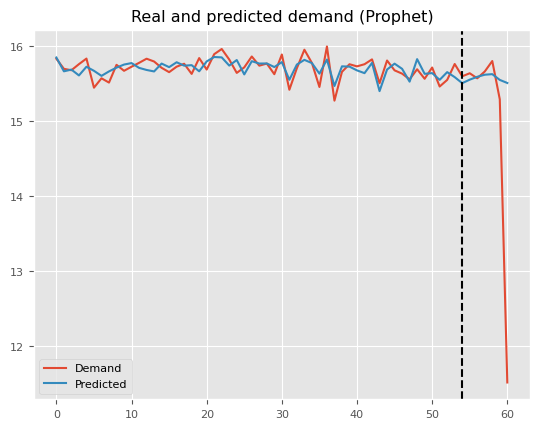

In [36]:
data_prophet.y.plot()
ax = pd.concat([train_hat, test_hat]).plot(title="Real and predicted demand (Prophet)")
ax.axvline(data_prophet.index[n_train], color="black", linestyle="--")
ax.legend(["Demand", "Predicted"])

Prophet provides beautiful plots out of the box:

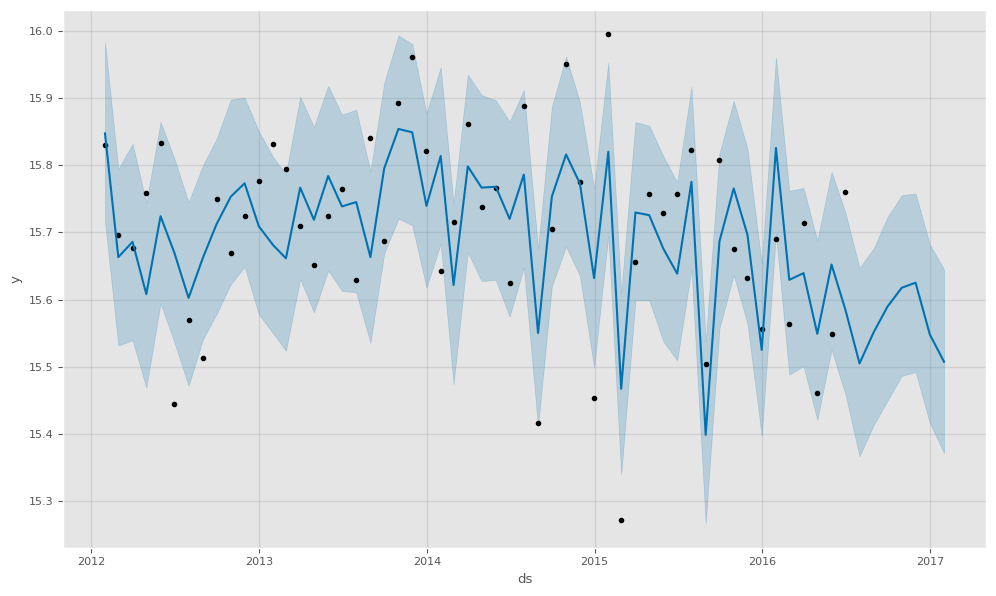

In [37]:
fig1 = m.plot(forecast)

Finally, let's evaluate these predictions. We see that this model is better at fitting the training data, but just slightly better with the test data

In [38]:
train_score = sqrt(mean_squared_error(data_train.y, train_hat))
print(f'Train RMSE: {train_score:.3f}')
test_score = sqrt(mean_squared_error(data_test.y, test_hat))
print(f'Test RMSE: {test_score:.3f}')

Train RMSE: 0.105
Test RMSE: 1.515


# Conclusions

In this notebook we have explored demand data, made some analysis and visualizations, and finally implemented some predictive models. For future work, we could for example try to tune the model parameters and we could improve our evaluation method.